## How To Use This Notebook

1. Copy osm_pbf_data_extractor.py into the first cell

# Main Script

In [9]:
# This script does the following
# 1. Downloads OSM files for specified countries from Geofabrik
# 2. Filters files for substations and lines
# 3. Process and clean data
# 4. Exports to CSV
# 5. Exports to GeoJson

"""
OSM extraction scrpt
"""

import os
import sys

# IMPORTANT: RUN SCRIPT FROM THIS SCRIPTS DIRECTORY i.e data_exploration/ TODO: make more robust
# os.chdir(os.path.dirname(os.path.abspath(__file__)))
sys.path.append('../')  # to import helpers

import logging
import shutil

import geopandas as gpd
import numpy as np
import pandas as pd
import requests
from esy.osmfilter import run_filter
from esy.osmfilter import Node, Relation, Way
from esy.osmfilter import osm_info as osm_info
from esy.osmfilter import osm_pickle as osm_pickle
from scripts.osm_data_config import world_countries
from shapely.geometry import LineString, Point

logger = logging.getLogger(__name__)

# https://gitlab.com/dlr-ve-esy/esy-osmfilter/-/tree/master/


# import logging
# logging.basicConfig()
# logger=logging.getLogger(__name__)
# logger.setLevel(logging.INFO)
# logger.setLevel(logging.WARNING)

# Downloads PBF File for given Country Code


def download_pbf(country_code, update):
    """
    Downloads the pbf file from geofabrik for a given country code (see scripts/osm_data_config.py).

    Parameters
    ----------
    country_code : str
    update : bool
        name of the network component
        update = true forces re-download of files
    """
    country_name = world_countries[country_code]
    # Filename for geofabrik
    geofabrik_filename = f"{country_name}-latest.osm.pbf"
    # https://download.geofabrik.de/africa/nigeria-latest.osm.pbf
    geofabrik_url = f"https://download.geofabrik.de/africa/{geofabrik_filename}"
    PBF_inputfile = os.path.join(
        os.getcwd(), "data", "osm", "pbf", geofabrik_filename
    )  # Input filepath

    if not os.path.exists(PBF_inputfile) or update is True:
        print(f"{geofabrik_filename} does not exist, downloading to {PBF_inputfile}")
        #  create data/osm directory
        os.makedirs(os.path.dirname(PBF_inputfile), exist_ok=True)
        with requests.get(geofabrik_url, stream=True) as r:
            with open(PBF_inputfile, "wb") as f:
                shutil.copyfileobj(r.raw, f)

    return PBF_inputfile


def download_and_filter(country_code, update=False):
    PBF_inputfile = download_pbf(country_code, update)

    filter_file_exists = False
    # json file for the Data dictionary
    JSON_outputfile = os.path.join(
        os.getcwd(), "data", "osm", country_code + "_power.json"
    )  # json file for the Elements dictionary is automatically written to "data/osm/Elements"+filename)

    if os.path.exists(JSON_outputfile):
        filter_file_exists = True

    # Load Previously Pre-Filtered Files
    if update is False and filter_file_exists is True:
        create_elements = False  # Do not create elements again
        new_prefilter_data = False  # Do not pre-filter data again
        # HACKY: esy.osmfilter code to re-create Data.pickle
        Data = osm_info.ReadJason(JSON_outputfile, verbose="no")
        DataDict = {"Data": Data}
        osm_pickle.picklesave(
            DataDict,
            os.path.realpath(
                os.path.join(os.getcwd(), os.path.dirname(JSON_outputfile))
            ),
        )
        print(f"Loading Pickle for {world_countries[country_code]}")  # TODO: Change to Logger
    else:
        create_elements = True
        new_prefilter_data = True
        print(
            f"Creating  New Elements for {world_countries[country_code]}"
        )  # TODO: Change to Logger

    prefilter = {
        Node: {"power": ["substation", "line", "generator"]},
        Way: {"power": ["substation", "line", "generator"]},
        Relation: {"power": ["substation", "line", "generator"]},
    }  # see https://dlr-ve-esy.gitlab.io/esy-osmfilter/filter.html for filter structures
    # HACKY: due to esy.osmfilter validation

    blackfilter = [
        ("", ""),
    ]

    for feature in ["substation", "line", "generator"]:
        whitefilter = [
            [
                ("power", feature),
            ],
        ]
        elementname = f"{country_code}_{feature}s"

        feature_data = run_filter(
            elementname,
            PBF_inputfile,
            JSON_outputfile,
            prefilter,
            whitefilter,
            blackfilter,
            NewPreFilterData=new_prefilter_data,
            CreateElements=create_elements,
            LoadElements=True,
            verbose=False,
            multiprocess=True,
        )

        if feature == "substation":
            substation_data = feature_data
        if feature == "line":
            line_data = feature_data
        if feature == "generator":
            generator_data = feature_data

    return (substation_data, line_data, generator_data)


# Convert Ways to Point Coordinates


# TODO: Use shapely and merge with convert_ways_lines
def convert_ways_nodes(df_way, Data):
    lonlat_column = []
    col = "refs"
    df_way[col] = (
        pd.Series().astype(float) if col not in df_way.columns else df_way[col]
    )  # create empty "refs" if not in dataframe
    for ref in df_way["refs"]:
        lonlats = []
        for r in ref:
            lonlat = Data["Node"][str(r)]["lonlat"]
            lonlats.append(lonlat)
        lonlats = np.array(lonlats)
        lonlat = np.mean(lonlats, axis=0)  # Hacky Apporx Centroid
        lonlat_column.append(lonlat)
    df_way.drop("refs", axis=1, inplace=True, errors="ignore")
    df_way.insert(0, "lonlat", lonlat_column)


# Convert Ways to Line Coordinates


def convert_ways_lines(df_way, Data):
    lonlat_column = []
    for ref in df_way["refs"]:  # goes through each row in df_way["refs"]
        lonlats = []
        # picks each element in ref & replaces ID by coordinate tuple (A multiline consist of several points)
        for r in ref:
            # "r" is the ID in Data["Node"], ["lonlat"] a list of [x1,y1] (coordinates)
            lonlat = Data["Node"][str(r)]["lonlat"]
            lonlat = tuple(lonlat)
            lonlats.append(lonlat)  # a list with tuples
        lonlat_column.append(lonlats)  # adding a new list of tuples every row
    df_way.drop("refs", axis=1, inplace=True)
    df_way.insert(1, "lonlat", lonlat_column)


# Convert Points Pandas Dataframe to GeoPandas Dataframe


def convert_pd_to_gdf(df_way):
    gdf = gpd.GeoDataFrame(df_way, geometry=[Point(x, y) for x, y in df_way.lonlat], crs="EPSG:4326")
    gdf.drop(columns=["lonlat"], inplace=True)
    return gdf


# Convert Lines Pandas Dataframe to GeoPandas Dataframe


def convert_pd_to_gdf_lines(df_way, simplified=False):
    df_way["geometry"] = df_way["lonlat"].apply(lambda x: LineString(x))
    if simplified is True:
        df_way["geometry"] = df_way["geometry"].apply(
            lambda x: x.simplify(0.005, preserve_topology=False)
        )
    gdf = gpd.GeoDataFrame(df_way, geometry="geometry", crs="EPSG:4326")
    gdf.drop(columns=["lonlat"], inplace=True)

    return gdf


# Convert Filtered Data, Elements to Pandas Dataframes


def convert_filtered_data_to_dfs(country_code, feature_data, feature):
    [Data, Elements] = feature_data
    elementname = f"{country_code}_{feature}s"
    df_way = pd.json_normalize(Elements[elementname]["Way"].values())
    df_node = pd.json_normalize(Elements[elementname]["Node"].values())
    return (df_node, df_way, Data)


def process_substation_data(country_code, substation_data):
    df_node, df_way, Data = convert_filtered_data_to_dfs(
        country_code, substation_data, "substation"
    )
    convert_ways_nodes(df_way, Data)
    # Add Type Column
    df_node["Type"] = "Node"
    df_way["Type"] = "Way"

    df_combined = pd.concat([df_node, df_way], axis=0)
    # Add Country Column
    df_combined["Country"] = world_countries[country_code]

    return df_combined


def process_line_data(country_code, line_data):
    df_node, df_way, Data = convert_filtered_data_to_dfs(
        country_code, line_data, "line"
    )
    convert_ways_lines(df_way, Data)
    # Add Type Column
    df_way["Type"] = "Way"

    # Add Country Column
    df_way["Country"] = world_countries[country_code]
    return df_way


def process_generator_data(country_code, generator_data):
    df_node, df_way, Data = convert_filtered_data_to_dfs(
        country_code, generator_data, "generator"
    )
    convert_ways_nodes(df_way, Data)
    # Add Type Column
    df_node["Type"] = "Node"
    df_way["Type"] = "Way"

    df_combined = pd.concat([df_node, df_way], axis=0)
    # Add Country Column
    df_combined["Country"] = world_countries[country_code]

    return df_combined


def process_data():
    df_all_substations = pd.DataFrame()
    df_all_lines = pd.DataFrame()
    df_all_generators = pd.DataFrame()
    test_CC = {"NG": "nigeria"}
    for country_code in test_CC.keys():
        substation_data, line_data, generator_data = download_and_filter(country_code)
        for feature in ["substation", "line", "generator"]:
            if feature == "substation":
                df_substation = process_substation_data(country_code, substation_data)
                df_all_substations = pd.concat([df_all_substations, df_substation])
            if feature == "line":
                df_line = process_line_data(country_code, line_data)
                df_all_lines = pd.concat([df_all_lines, df_line])
            if feature == "generator":
                df_generator = process_generator_data(country_code, generator_data)
                df_all_generators = pd.concat([df_all_generators, df_generator])

    # ----------- SUBSTATIONS -----------

    # Columns of interest
    df_all_substations = df_all_substations[
        df_all_substations.columns &
        [
            "id",
            "lonlat",
            "tags.power",
            "tags.substation",
            "tags.voltage",
            "tags.frequency",
            "Type",
            "Country",
        ]
    ]
    df_all_substations.drop(df_all_substations.loc[df_all_substations['tags.substation']=='industrial'].index, inplace=True) # Drop industrial substations
    df_all_substations.drop(df_all_substations.loc[df_all_substations['tags.substation']=='distribution'].index, inplace=True) # Drop distribution substations

    # Generate Files
    outputfile_partial = os.path.join(
        os.getcwd(), "data", "africa_all" + "_substations."
    )
    df_all_substations.to_csv(outputfile_partial + "csv")  # Generate CSV
    gdf_substations = convert_pd_to_gdf(df_all_substations)
    gdf_substations.to_file(
        outputfile_partial + "geojson", driver="GeoJSON"
    )  # Generate GeoJson

    # ----------- LINES -----------

    # Columns of interest
    df_all_lines = df_all_lines[
        df_all_lines.columns &
        [
            "id",
            "lonlat",
            "tags.power",
            "tags.cables",
            "tags.voltage",
            "tags.circuits",
            "tags.frequency",
            "Type",
            "Country",
        ]
    ]
    # Generate Files
    outputfile_partial = os.path.join(os.getcwd(), "data", "africa_all" + "_lines.")
    df_all_lines.to_csv(outputfile_partial + "csv")  # Generate CSV
    gdf_lines = convert_pd_to_gdf_lines(df_all_lines, simplified=True)
    gdf_lines.to_file(
        outputfile_partial + "geojson", driver="GeoJSON"
    )  # Generate GeoJson

    # ----------- Generator -----------

    # Columns of interest
    df_all_generators = df_all_generators[
        df_all_generators.columns &
        [
            "id",
            "lonlat",
            "tags.power",
            "tags.generator:type",
            "tags.generator:method",
            "tags.generator:source",
            "tags.generator:output:electricity",
            "Type",
            "Country",
        ]
    ]
    # Generate Files
    outputfile_partial = os.path.join(
        os.getcwd(), "data", "africa_all" + "_generators."
    )
    df_all_generators.to_csv(outputfile_partial + "csv")  # Generate CSV
    gdf_generators = convert_pd_to_gdf(df_all_generators)
    gdf_generators.to_file(
        outputfile_partial + "geojson", driver="GeoJSON"
    )  # Generate GeoJson


# Overwrite Functions

In [10]:
# New function

def lonlat_lookup(df_way, Data):
    lonlat_list = []

    col = "refs"
    if col not in df_way.columns:
        print ("refs column not found")
        df_way[col] = pd.Series().astype(float) # create empty "refs" if not in dataframe
      
    for ref in df_way["refs"]:
        lonlat_row = []
        for r in ref:
            lonlat = tuple(Data["Node"][str(r)]["lonlat"])
            lonlat_row.append(lonlat)
        lonlat_list.append(lonlat_row)
    return lonlat_list

from shapely.geometry import Polygon

def convert_ways_point(df_way, Data):
    lonlat_list = lonlat_lookup(df_way, Data)
    lonlat_column = []
    area_column = []
    for lonlat in lonlat_list:
        way_polygon = Polygon(lonlat)
        polygon_area = int(round(gpd.GeoSeries(way_polygon).set_crs("EPSG:4326").to_crs("EPSG:3857").area, -1)) # nearest tens
        # print('{:g}'.format(float('{:.3g}'.format(float(polygon_area))))) # For significant numbers
        area_column.append(polygon_area)
        center_point = way_polygon.centroid
        lonlat_column.append(list((center_point.x, center_point.y)))

    # df_way.drop("refs", axis=1, inplace=True, errors="ignore")
    df_way.insert(0, "lonlat", lonlat_column)
    

In [11]:
df_all_substations = pd.DataFrame()
df_all_lines = pd.DataFrame()
df_all_generators = pd.DataFrame()
test_CC = {"NA": "namibia"}
for country_code in test_CC.keys():
    substation_data, line_data, generator_data = download_and_filter(country_code)
    for feature in ["substation", "line","generator"]:
        if feature == 'substation':
            df_substation = process_substation_data(country_code, substation_data)
            df_all_substations = pd.concat(
                [df_all_substations, df_substation])
        if feature == 'line':
            df_line = process_line_data(country_code, line_data)
            df_all_lines = pd.concat([df_all_lines, df_line])
        if feature == 'generator':
            df_generator = process_generator_data(country_code, generator_data)
            df_all_generators = pd.concat(
                [df_all_generators, df_generator])

namibia-latest.osm.pbf does not exist, downloading to c:\Users\Davide\Git\pypsa-africa\data\osm\pbf\namibia-latest.osm.pbf
Creating  New Elements for namibia


# Substations

In [12]:
#----------- SUBSTATIONS -----------

# Clean
df_all_substations.reset_index(drop=True, inplace=True)
df_all_substations.dropna(thresh=len(df_all_substations)*0.25, axis=1, how='all', inplace = True) #Drop Columns with 75% values as N/A
df_all_substations.dropna(subset=['tags.voltage'], inplace = True) # Drop any substations with Voltage = N/A
df_all_substations.drop(df_all_substations.loc[df_all_substations['tags.substation']=='industrial'].index, inplace=True)
df_all_substations.drop(df_all_substations.loc[df_all_substations['tags.substation']=='distribution'].index, inplace=True)

# Generate Files
outputfile_partial = os.path.join(os.getcwd(),'data','africa_all'+'_substations.')
df_all_substations.to_csv(outputfile_partial + 'csv') # Generate CSV
gdf_substations = convert_pd_to_gdf(df_all_substations.drop('refs', 1))
gdf_substations.to_file(outputfile_partial+'geojson', driver="GeoJSON")  # Generate GeoJson

In [13]:
df_all_substations

,id,lonlat,tags.power,tags.substation,Type,refs,tags.voltage,tags.location,Country
15,567535340,"[3.6095873558889786, 7.966471112628691]",substation,transmission,Way,"[5462602236, 5462602234, 5462602233, 546260223...",132000,outdoor,nigeria
16,592191538,"[3.396022912531792, 6.52091363501559]",substation,transmission,Way,"[5652509019, 5652509020, 5652509121, 565250912...",132000,NaN,nigeria
18,655273140,"[13.082073150000024, 11.74032315000003]",substation,transmission,Way,"[6139631838, 6139631837, 6139631836, 613963183...",330000;132000,outdoor,nigeria
23,563723584,"[12.033159502527408, 11.723129410925631]",substation,transmission,Way,"[6533861857, 5432184095, 6533861856, 543218409...",330000;132000,outdoor,nigeria
24,565081403,"[8.56963233207296, 7.626614493430781]",substation,transmission,Way,"[5443125654, 5443125653, 5443125652, 544312565...",330000;132000,outdoor,nigeria
26,565868863,"[7.922956391185345, 4.651729869521267]",substation,transmission,Way,"[5448674473, 5448674472, 5448674471, 544867447...",132000,outdoor,nigeria
27,334825256,"[7.680536364509827, 5.153117009567657]",substation,transmission,Way,"[3419395707, 3419395693, 3419395695, 341939569...",330000,outdoor,nigeria
28,540463591,"[4.791330849100031, 9.140766592640382]",substation,transmission,Way,"[5228649182, 5228649181, 5228649180, 522864917...",330000,outdoor,nigeria
32,671706478,"[6.672202257846987, 6.180953062671381]",substation,transmission,Way,"[6290115064, 6290115063, 6290115062, 629011506...",330000;132000,outdoor,nigeria
33,671893504,"[6.802414144564438, 6.116840988573075]",substation,transmission,Way,"[5343486795, 6291846734, 6291846733, 629184673...",330000;132000,outdoor,nigeria


# Generators

In [14]:
# ----------- Generator -----------

df_all_generators.reset_index(drop=True, inplace=True)
df_all_generators.drop(columns = ["tags.fixme","tags.frequency","tags.name:ar","tags.building","tags.barrier"], inplace = True, errors='ignore')
df_all_generators = df_all_generators[df_all_generators['tags.generator:output:electricity'].astype(str).str.contains('MW')] #removes boolean 
df_all_generators['tags.generator:output:electricity'] = df_all_generators['tags.generator:output:electricity'].str.extract('(\d+)').astype(float)
df_all_generators.rename(columns = {'tags.generator:output:electricity':"power_output_MW"}, inplace = True)
# df_all_generators.dropna(thresh=len(df_all_generators)*0.25, axis=1, how='all', inplace=True) # Drop Columns with 75% values as N/A

# # Generate Files
# outputfile_partial = os.path.join(os.getcwd(),'data','africa_all'+'_generators.')
# df_all_generators.to_csv(outputfile_partial + 'csv') # Generate CSV
# gdf_generators = convert_pd_to_gdf(df_all_generators)
# gdf_generators.to_file(outputfile_partial+'geojson', driver="GeoJSON")  # Generate GeoJson

In [15]:
df_all_generators

,id,lonlat,tags.name,tags.power,tags.source,tags.generator:type,tags.generator:method,tags.generator:source,power_output_MW,tags.operator,tags.description,tags.manufacturer,tags.start_date,Type,refs,Country
5,7805160134,"[6.66302290000007, 5.39017029999977]",NaN,generator,NaN,gas_turbine,combustion,gas,25.0,NaN,NaN,NaN,NaN,Node,NaN,nigeria
11,7808382697,"[5.645223299999995, 5.924997999999995]",NaN,generator,http://nerp.abv.ng/index.php/power-plants/sape...,steam_turbine,combustion,gas,120.0,Sapele Power,NaN,NaN,NaN,Node,NaN,nigeria
12,7804096584,"[4.78933260000001, 9.139945099999972]",NaN,generator,NaN,kaplan_turbine,run-of-the-river,hydro,96.0,NaN,NaN,NaN,NaN,Node,NaN,nigeria
14,7804096571,"[5.91642560000001, 5.54205519999997]",NaN,generator,NaN,gas_turbine,combustion,gas,25.0,NaN,NaN,NaN,NaN,Node,NaN,nigeria
16,7805160138,"[6.66355510000007, 5.390166099999769]",NaN,generator,NaN,gas_turbine,combustion,gas,25.0,NaN,NaN,NaN,NaN,Node,NaN,nigeria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,7808382705,"[5.6440999999999955, 5.927484399999995]",NaN,generator,http://nerp.abv.ng/index.php/power-plants/sape...,gas_turbine,combustion,gas,75.0,Sapele Power,NaN,NaN,NaN,Node,NaN,nigeria
302,7808377978,"[8.272184699999995, 5.190881999999995]",NaN,generator,NaN,gas_turbine,combustion,gas,112.0,NaN,NaN,NaN,NaN,Node,NaN,nigeria
306,215459541,"[6.658820460036619, 7.469321816342016]",GT13,generator,NaN,NaN,combustion,gas,138.0,NaN,NaN,NaN,NaN,Way,"[2249105432, 2249105417, 2249105438, 224910544...",nigeria
340,215459539,"[6.658996299999985, 7.469614549999994]",GT12,generator,NaN,NaN,combustion,gas,138.0,NaN,NaN,NaN,NaN,Way,"[2249105467, 2249105457, 2249105469, 224910547...",nigeria


# Lines

In [16]:
# ----------- LINES -----------

# Clean
# TODO: FIX Voltage Filter
# Some transmission lines carry multiple voltages, having voltage_V = 10000;20000  (two lines)
# The following code keeps only the first information before the semicolon..
# Needs to be corrected in future, creating two lines with the same bus ID.


df_all_lines = df_all_lines[
        {
            "id",
            "refs",
            "lonlat",
            "tags.power",
            "tags.cables",
            "tags.voltage",
            "tags.frequency",
            "Type",
            "Country",
        }
    ]

# Clean data    
df_all_lines = df_all_lines.reset_index(drop=True)
df_all_lines = df_all_lines.dropna(subset=['tags.voltage']) # Drop any lines with Voltage = N/A
df_all_lines = df_all_lines.rename(columns = {'tags.voltage':"voltage_V"}) 
df_all_lines['voltage_V'] = df_all_lines['voltage_V'].str.split('*').str[0] #just keeps the 
df_all_lines['voltage_V'] = df_all_lines['voltage_V'].str.split(';').str[0]
df_all_lines['voltage_V'] = df_all_lines['voltage_V'].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna() ## if cell can't converted to float -> drop
df_all_lines = df_all_lines[df_all_lines.voltage_V > 10000]
# df_all_lines['end_refs'] = 

# Generate Files
outputfile_partial = os.path.join(os.getcwd(), 'data', 'africa_all'+'_lines.')  
df_all_lines.to_csv(outputfile_partial + 'csv')  # Generate CSV
gdf_lines = convert_pd_to_gdf_lines(df_all_lines.drop('refs', 1), simplified=True)
gdf_lines.to_file(outputfile_partial+'geojson',
            driver="GeoJSON")  # Generate GeoJson

In [17]:
df_line_lookup = df_all_lines[['id','refs']]
display(df_line_lookup)

,id,refs
2,556530547,"[2725719269, 2725912800, 2725719240, 272571923..."
3,671706473,"[6290115060, 6290115059, 6290115058, 629011505..."
6,108020973,"[5198712394, 3064004782, 3064004786, 306400479..."
7,671606207,"[5282666532, 6289294708, 5282666526]"
8,575700599,"[5448403687, 5448403686]"
...,...,...
647,563719558,"[5432136688, 5432136687, 5432136686, 543213668..."
649,565151711,"[5443838099, 5443838095, 5443838091, 544383809..."
650,669957218,"[6274221446, 6274221432, 6274221440, 627422144..."
651,564385545,"[5437840807, 6291806172, 6291806173, 629180617..."


In [18]:
df_node_lookup = df_all_substations[['id','refs']]
df_node_lookup = df_node_lookup.dropna(subset=['refs']) # Drop any nodes with refs = N/A
display(df_node_lookup)

,id,refs
15,567535340,"[5462602236, 5462602234, 5462602233, 546260223..."
16,592191538,"[5652509019, 5652509020, 5652509121, 565250912..."
18,655273140,"[6139631838, 6139631837, 6139631836, 613963183..."
23,563723584,"[6533861857, 5432184095, 6533861856, 543218409..."
24,565081403,"[5443125654, 5443125653, 5443125652, 544312565..."
26,565868863,"[5448674473, 5448674472, 5448674471, 544867447..."
27,334825256,"[3419395707, 3419395693, 3419395695, 341939569..."
28,540463591,"[5228649182, 5228649181, 5228649180, 522864917..."
32,671706478,"[6290115064, 6290115063, 6290115062, 629011506..."
33,671893504,"[5343486795, 6291846734, 6291846733, 629184673..."


In [19]:
def flatten_df(df):
    out = []
    for n, row in df.iterrows():
        for item in row['refs']:
            row['flat_ref'] = item
            out += [row.copy()]

    flattened_df = pd.DataFrame(out)
    flattened_df.reset_index(drop=True, inplace=True)

    return flattened_df

In [20]:
way_f = flatten_df(df_line_lookup)
display(way_f)

,id,refs,flat_ref
0,556530547,"[2725719269, 2725912800, 2725719240, 272571923...",2725719269
1,556530547,"[2725719269, 2725912800, 2725719240, 272571923...",2725912800
2,556530547,"[2725719269, 2725912800, 2725719240, 272571923...",2725719240
3,556530547,"[2725719269, 2725912800, 2725719240, 272571923...",2725719238
4,556530547,"[2725719269, 2725912800, 2725719240, 272571923...",5368625277
...,...,...,...
32133,695800745,"[6533692645, 6533692646, 6533692647, 653369264...",6533703128
32134,695800745,"[6533692645, 6533692646, 6533692647, 653369264...",6533703129
32135,695800745,"[6533692645, 6533692646, 6533692647, 653369264...",6533703130
32136,695800745,"[6533692645, 6533692646, 6533692647, 653369264...",6533703131


In [21]:
node_f = flatten_df(df_node_lookup)
display(node_f)

,id,refs,flat_ref
0,567535340,"[5462602236, 5462602234, 5462602233, 546260223...",5462602236
1,567535340,"[5462602236, 5462602234, 5462602233, 546260223...",5462602234
2,567535340,"[5462602236, 5462602234, 5462602233, 546260223...",5462602233
3,567535340,"[5462602236, 5462602234, 5462602233, 546260223...",5462602232
4,567535340,"[5462602236, 5462602234, 5462602233, 546260223...",5462602236
...,...,...,...
443,567184002,"[5460459805, 5460459804, 5460459803, 546045980...",5460459805
444,567184002,"[5460459805, 5460459804, 5460459803, 546045980...",5460459804
445,567184002,"[5460459805, 5460459804, 5460459803, 546045980...",5460459803
446,567184002,"[5460459805, 5460459804, 5460459803, 546045980...",5460459802


In [22]:
df3 = way_f.merge(node_f, on='flat_ref', how='inner')
display(df3)

,id_x,refs_x,flat_ref,id_y,refs_y


In [23]:
all_line_refs = set()
for ref in df_all_lines["refs"]:  # goes through each row in df_way['refs']
    for r in ref:
        all_line_refs.add(r)



In [24]:
all_st_refs = set()
for ref in df_all_substations.dropna(subset=['refs'])["refs"]:  # goes through each row in df_way['refs']
    for r in ref:
        all_st_refs.add(r)

In [25]:
# all_line_refs

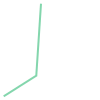

In [45]:
lines.geometry.loc[0]

C:\ProgramData\Miniconda3\envs\toast\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

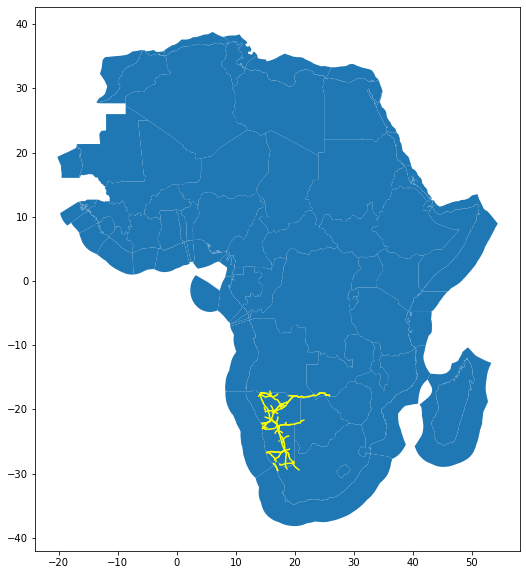

In [50]:
# plot raw data


continent = gpd.read_file('resources/country_shapes.geojson')
off_shore = gpd.read_file('resources/offshore_shapes.geojson')
off_shore_old = gpd.read_file('resources/offshore_shapes_old.geojson')
gadm = gpd.read_file('resources/gadm_shapes.geojson')

df_all_lines2 = df_all_lines.copy()
df_all_lines2 = df_all_lines2[~df_all_lines2["tags.voltage"].isna()]
df_all_lines2["geometry"] = [LineString(x.lonlat) for index, x in df_all_lines2.iterrows()]
lines = gpd.GeoDataFrame(geometry=df_all_lines2.geometry, crs='epsg:4326')

ax = continent.plot(figsize=(10,10))
off_shore.plot(ax=ax)
lines.plot(ax=ax, color="yellow")

In [51]:
df_all_lines2

,id,lonlat,tags.fixme,tags.power,tags.cables,tags.voltage,tags.operator,tags.wires,tags.line,tags.frequency,tags.circuits,tags.name,tags.source,tags.note,tags.created_by,tags.design_voltage,tags.designation,Type,Country,geometry
1,624698435,"[(18.296949299999916, -26.418113300000012), (1...",NaN,line,NaN,66000,NamPower,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Way,namibia,LINESTRING (18.29694929999992 -26.418113300000...
3,352048992,"[(15.811191799999985, -21.924046099999945), (1...",NaN,line,3,220000,NaN,single,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Way,namibia,LINESTRING (15.81119179999999 -21.924046099999...
5,381807608,"[(15.81279950000001, -21.929019799999974), (15...",NaN,line,NaN,66000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Way,namibia,LINESTRING (15.81279950000001 -21.929019799999...
6,664681169,"[(15.747225699999978, -17.74940669999994), (15...",NaN,line,NaN,66000,NaN,NaN,bay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Way,namibia,LINESTRING (15.74722569999998 -17.749406699999...
8,701923223,"[(18.973294799999962, -22.44084039999996), (18...",NaN,line,3,66000,NaN,NaN,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Way,namibia,LINESTRING (18.97329479999996 -22.440840399999...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,108549123,"[(14.736323599999965, -22.768767800000063), (1...","name,operaor,frequency",line,3,66000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Way,namibia,LINESTRING (14.73632359999996 -22.768767800000...
369,714424383,"[(17.58704870000014, -24.69549400000003), (17....",NaN,line,NaN,33000,NamPower,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Way,namibia,LINESTRING (17.58704870000014 -24.695494000000...
371,381288193,"[(15.089035800000023, -22.84305040000003), (15...",NaN,line,NaN,66000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Way,namibia,LINESTRING (15.08903580000002 -22.843050400000...
372,192947275,"[(17.66715330000009, -28.656334699999714), (17...",NaN,line,NaN,132000,NaN,NaN,NaN,NaN,NaN,NaN,Bing Hires Aerial Image,NaN,NaN,NaN,NaN,Way,namibia,LINESTRING (17.66715330000009 -28.656334699999...
